In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np #verify the version for tensorflow
np.__version__

'1.21.0'

In [3]:
import tensorflow as tf #for machine learning and parametric UMAP
import tensorflow_datasets as tfds
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.8.0
Num GPUs Available:  1
Num CPUs Available:  1


In [4]:
from scipy.special import expit as activation_function #for custom machine learning method
from scipy.stats import truncnorm

In [5]:
import scvelo as scv #for velocity embedding 

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import random
%matplotlib inline
from umap.parametric_umap import ParametricUMAP

In [7]:
from math import acos
from math import sqrt
from math import pi
from sklearn import preprocessing

import matplotlib.cm as cm

# <b>velocity embedding method using UMAP<b>

process :

- use UMAP parametrization to "learn" a function that go from 3D to 2D (on cells data)
- use this function to translate the velocity vector fied in 2D
- reverse the parametrisation in order to compare

test : 

- generate random cells in 3D and a random velocity vector field on it.
- go from 3D to 2D using the embedding method
- use the reverse function to go from 2D to 3D again
- compare reconstruction with original data 

# Plot

In [8]:
def Plot2D(C,save = '') :
    #plot
    plt.figure(figsize=(12, 12))
    plt.title("UMAP simulation embedding")
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(C[:, 0],
    C[:, 1])
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [9]:
def plot3D(E,save = '') :
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('simulation of cells')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    #ax.set_xlim(-1,1)
    #ax.set_ylim(-1,1)
    #ax.set_zlim(-1,1)
    
    ax.scatter(E[:, 0],E[:, 1],E[:, 2])
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')
        
    plt.show()

In [10]:
def plot_epoch(E,reconstruction,save = ''):
    
    plt.figure(figsize=(12, 12))
    plt.title("Minimisation of the cross entropy")
    if reconstruction :
        plt.plot(E._history['umap_loss'])
    else :
        plt.plot(E._history['loss'])
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')
        
    plt.show()

In [60]:
def Vector_plot(embedding,velocity,save = '',color = False) :
   
    if(velocity.shape[1] == 2) :
        norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2) #normalisation
        velocity[:, 0] = velocity[:, 0]/norm
        velocity[:, 1] = velocity[:, 1]/norm
        if(color == True) :
            col = np.random.rand(velocity.shape[0])
            for i in range(velocity.shape[0]) :
                col[i] = angle_of_vector([1,0],velocity[i,:])
        
    #plot
    plt.figure(figsize=(12, 12))
    plt.title("Velocity embedding on UMAP")
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.scatter(embedding[:, 0], embedding[:, 1])
    
    
    if(color == False) :
        plt.quiver(embedding[:, 0],embedding[:, 1],velocity[:, 0],velocity[:, 1])
    else :
        plt.quiver(embedding[:, 0],embedding[:, 1],velocity[:, 0],velocity[:, 1],col, cmap = 'magma')
        
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [68]:
def angle_of_vector(v1, v2):
    vector_prod = v1[0] * v2[0] + v1[1] * v2[1]
    length_prod = sqrt(pow(v1[0], 2) + pow(v1[1], 2)) * sqrt(pow(v2[0], 2) + pow(v2[1], 2))
    cos = vector_prod * 1.0 / (length_prod * 1.0 + 1e-6)
    return (acos(cos) / pi) * 180


def Vector_plot3D(embedding,velocity, save = '') :
   
    if(velocity.shape[1] == 3) :
        norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2 + velocity[:, 2]**2)*10 #normalisation
        velocity[:, 0] = velocity[:, 0]/norm
        velocity[:, 1] = velocity[:, 1]/norm
        velocity[:, 2] = velocity[:, 2]/norm
        

        
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(embedding[:, 0],embedding[:, 1],embedding[:, 2])
    ax.quiver(embedding[:, 0],embedding[:, 1],embedding[:, 2],velocity[:, 0],velocity[:, 1],velocity[:, 2])

    ax.set_title('simulation of cells and velocities')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    #ax.set_xlim(-1,1)
    #ax.set_ylim(-1,1)
    #ax.set_zlim(-1,1)
    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'.png')

    plt.show()

In [13]:
def coloring(C,I,E,V, save = '') : #C original cells, I reconstructed data, E embedding
    dist = []
    for i in range(C.shape[0]) :
        dist.append(np.sqrt(np.sum(np.square(C[i]-I[i]))))
    
    #plot

    plt.figure(figsize=(12, 12))
    plt.title("colored UMAP cells embedding")
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.scatter(E[:, 0], E[:, 1],c = dist , cmap = "magma")
    plt.quiver(E[:, 0],E[:, 1],V[:, 0],V[:, 1])

    
    if(save != '') :
        plt.savefig(fname = 'graph/'+save+'_2D.png')
        
    plt.show()
    
    #plot
    if(C.shape[1] == 3) :
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')

        ax.scatter(C[:, 0],C[:, 1],C[:, 2], c = dist , cmap = "magma")

        ax.set_title('simulation of cells')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        #ax.set_xlim(-1,1)
        #ax.set_ylim(-1,1)
        #ax.set_zlim(-1,1)
        
        if(save != '') :
            plt.savefig(fname = 'graph/'+save+'_3D.png')
        
        plt.show()
    

# UMAP mapping

In [14]:
# UMAP embedding of cells (normal umap)

def umap_mapping(C, save = ''):
    fit = umap.UMAP(n_neighbors = 100) #use the normal embedding process
    embedding = fit.fit_transform(C) #fit
    #embedding = fit.fit_transform(data_p)

    #plot
    Plot2D(embedding, save)
    
    return embedding

# parametric UMAP mapping

In [15]:
# use parametric umap
def PUMAP_mapping(C, save = '', reconstruction = False):
    embedder = ParametricUMAP(parametric_reconstruction= reconstruction, verbose=True)
    embedding_param = embedder.fit_transform(C) # random
    
    Plot2D(embedding_param,save+' plot ')
    
    plot_epoch(embedder,reconstruction,save+' loss' )
    
    return embedder,embedding_param

In [16]:
# or custom network !

# Generate random numbers within a truncated (bounded) 
# normal distribution:
def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Create the ‘Nnetwork’ class and define its arguments:
# Set the number of neurons/nodes for each layer
# and initialize the weight matrices:  
class Nnetwork:

    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, 
                                        self.no_of_hidden_nodes))

    def train(self, input_vector, target_vector):
        pass # More work is needed to train the network
            
    def run(self, input_vector):
        """
        running the network with an input vector 'input_vector'. 
        'input_vector' can be tuple, list or ndarray
        """
        # Turn the input vector into a column vector:
        input_vector = np.array(input_vector, ndmin=2).T
        # activation_function() implements the expit function,
        # which is an implementation of the sigmoid function:
        input_hidden = activation_function(self.weights_in_hidden @   input_vector)
        output_vector = activation_function(self.weights_hidden_out @ input_hidden)
        return output_vector 

# use neural network to learn the UMAP model 

# Initialize an instance of the class:  
parametric_network = Nnetwork(no_of_in_nodes=2, 
                               no_of_out_nodes=2, 
                               no_of_hidden_nodes=4,
                               learning_rate=0.6)


# Embedding of the vector field with the UMAP mapping

In [17]:
def velocity_calculus(embedder,embedding, V,C,save = '') :
    velocity = embedder.transform(V + C) - embedding

    Vector_plot(embedding,velocity, save)
    
    return velocity

# inverse transform of the embedding

In [18]:
def inversion(embedder, embedding, save = '') :
    embedding_inverse = embedder.inverse_transform(embedding)
    #plot
    if(embedding_inverse.shape[1] == 3) :
        plot3D(embedding_inverse, save)
    
    return embedding_inverse

In [19]:
def dist(C,I) :
    if(C.shape[0] != 0) :
        return np.sum(np.sqrt(np.sum(np.square(C-I))))/C.shape[0]
    else :
        return "error : null dimension"

# velocity mapping using the gradiant

In [20]:
# compute the gradiant
def velocity_embedding(C,embedder,V) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    x = C # point in high dimension
    x = list(x)
    x = tf.constant(x)
    with tf.GradientTape() as t:
        t.watch(x)
        y = embedder.encoder(x)[:,0] #function learned by parametric UMAP
    
    dy_dx = t.gradient(y, x) # determine the gradiant
    
    with tf.GradientTape() as t:
        t.watch(x)
        z = embedder.encoder(x)[:,1]

    dz_dx = t.gradient(z, x)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    embedded_velocity = np.random.rand(V.shape[0], 2)
    for i in range(V.shape[0]) :
        v = [np.sum(dy_dx.numpy()[i,:]*V[i,:]),np.sum(dz_dx.numpy()[i,:]*V[i,:])]
        embedded_velocity[i] = v
        
    return embedded_velocity

In [21]:

def velocity_inversing(embedding,embedder,V) :

    #with this function we obtain a array, that represent the gradiant into each cells (in y and x) dy_dx.numpy()
    
    a = embedding # point in high dimension
    a = list(a)
    a = tf.constant(a)
    with tf.GradientTape() as t:
        t.watch(a)
        b = embedder.decoder(a) #function learned by parametric UMAP
    
    db_da = t.gradient(b, a)[:,0] # determine the gradiant
    
    with tf.GradientTape() as t:
        t.watch(a)
        c = embedder.decoder(a)[:,1]

    dc_da = t.gradient(c, a)
    
    with tf.GradientTape() as t:
        t.watch(a)
        d = embedder.decoder(a)[:,2]
    
    dd_da = t.gradient(d, a)
    
    #Now, can calculate the jacobian for each point and use it as a function from high to low dimension for the vector field.
    
    reconstructed_velocity = np.random.rand(V.shape[0], 3)
    for i in range(V.shape[0]) :
        v = [np.sum(db_da.numpy()[i]*V[i,:]),np.sum(dc_da.numpy()[i]*V[i,:]),np.sum(dd_da.numpy()[i]*V[i,:])]
        reconstructed_velocity[i] = v
        
    return reconstructed_velocity

In [22]:
def velocity_inverting(embedder,embedding, embedded_velo,C,save = '') :
    velocity_invert = embedder.inverse_transform(embedded_velo + embedding) - C 
    Vector_plot3D(C,velocity_invert)
    return velocity_invert

In [23]:
def normalise(X) : 
    n = X.shape[1]
    M = 0.0
    for i in range(n) : 
        m = max(X[:,i])
        if m > M :
            M = m
    if M != 0.0 :
        X = X/M
    return X

# <b>Application on artifial (or random) data<b>

# data generation

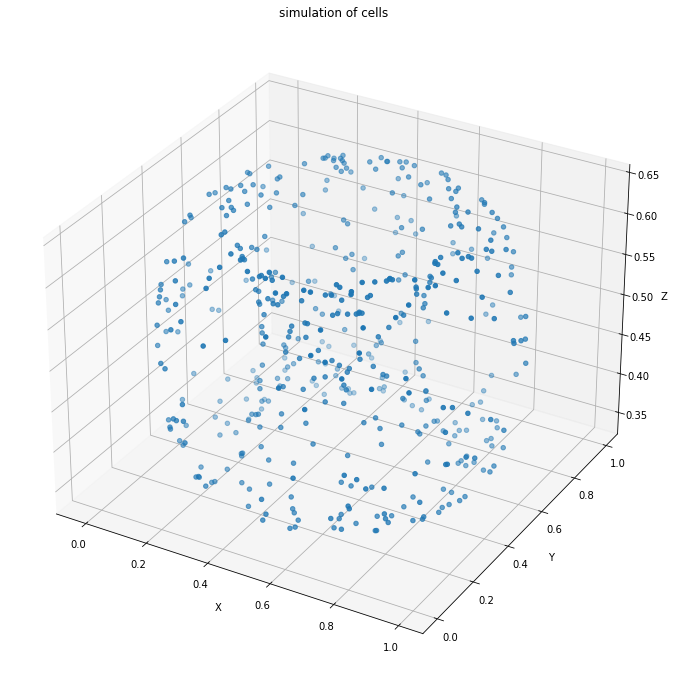

In [72]:
# generation of data (cells)

n = 500

#np.random.seed(42) #fix the seed

#random cells data

cells = np.random.rand(n, 3) 

#for ball data

#cells = np.random.rand(n, 3) 
#theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]
#cells[:, 0] = 10 +10*np.cos(theta)*np.sin(phi)
##cells[:, 1] = 10 +10*np.sin(theta)*np.sin(phi)
#cells[:, 2] = 10 +10*np.cos(phi)

#for line data

#cells = np.random.rand(n, 3) 
#cells[:, 0] = 0
#cells[:, 2] = 0

#for tore data

a = 0.75
b = 0.3
theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] 
phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]
cells[:, 0] = 10+10*(a+b*np.cos(theta))*np.cos(phi)
cells[:, 1] = 10+10*(a+b*np.cos(theta))*np.sin(phi)
cells[:, 2] = 10+10*b*np.sin(theta)

#for cluster data

#cells = np.random.rand(n, 3) 
#theta = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))]
#cells[0:int(n/2), 0] = 0.5*np.cos(theta)*np.sin(phi) - 0.2
#cells[0:int(n/2), 1] =  0.5*np.sin(theta)*np.sin(phi) - 0.2
#cells[0:int(n/2), 2] =  0.5*np.cos(phi) -1


#theta = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))] 
#phi = [random.uniform(0, 2*np.pi) for i in range(0, int(n/2))]
#cells[int(n/2):n, 0] =  100*0.5*np.cos(theta)*np.sin(phi) +0.2
#cells[int(n/2):n, 1] =  0.5*np.sin(theta)*np.sin(phi) +1
#cells[int(n/2):n, 2] =  0.5*np.cos(phi) + 0.2

#for reconstruction
cells = normalise(cells)

#plot
plot3D(cells,'simulation of cells_cluster')

[[0.83566256 0.42183888 0.35173861]
 [0.9169774  0.37943822 0.12320345]
 [0.83486828 0.45611229 0.30815019]
 ...
 [0.5876499  0.8086418  0.02767711]
 [0.6153894  0.60786319 0.501795  ]
 [0.55342403 0.72985667 0.40128678]]


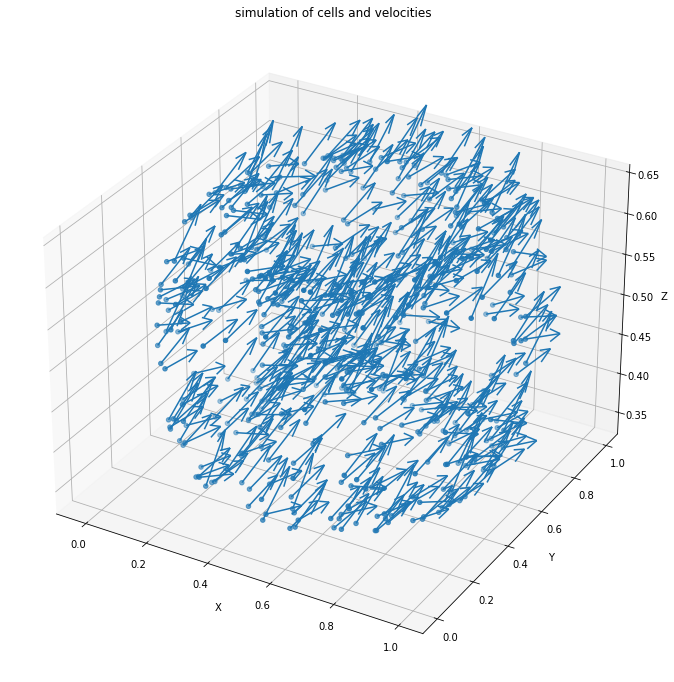

In [73]:
# generation of data (vector field)


velocity = np.random.rand(n, 3) #generate velocity random
#theta = [random.uniform(0, 2*np.pi) for i in range(0, n)] #for ball data
#phi = [random.uniform(0, 2*np.pi) for i in range(0, n)]

#velocity[:, 0] = np.sin(theta)*np.cos(phi)
#velocity[:, 1] = np.sin(theta)*np.sin(phi)
#velocity[:, 2] = np.cos(theta)

for i in range(velocity.shape[0]) :
    velocity[i, 0] = 4 + random.uniform(0, 2*np.pi) #generate velocity in a particular direction
    velocity[i, 1] = random.uniform(0, 2*np.pi)
    velocity[i, 2] = random.uniform(0, 2*np.pi)

norm = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2+ velocity[:, 2]**2) 
velocity[:, 0] = velocity[:, 0]/norm
velocity[:, 1] = velocity[:, 1]/norm
velocity[:, 2] = velocity[:, 2]/norm

#plot
print(velocity)

Vector_plot3D(cells,velocity, 'simulation of velocity_cluster')

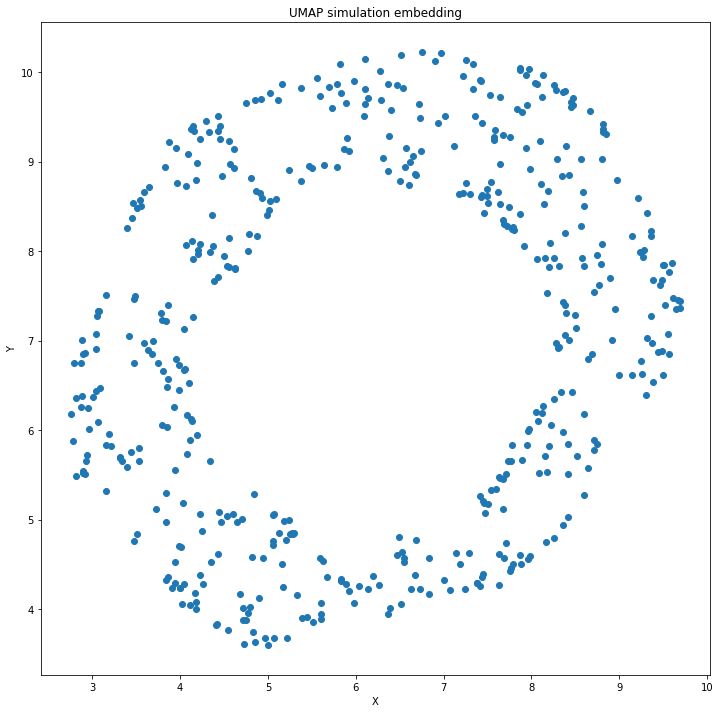

In [74]:
embedding = umap_mapping(cells,'simulation UMAP embedding_cluster', )

ParametricUMAP(optimizer=<keras.optimizer_v2.adam.Adam object at 0x2e226d370>, parametric_reconstruction=True)
Mon May 16 16:31:04 2022 Construct fuzzy simplicial set
Mon May 16 16:31:04 2022 Finding Nearest Neighbors
Mon May 16 16:31:04 2022 Finished Nearest Neighbor Search
Mon May 16 16:31:04 2022 Construct embedding
Epoch 1/10


2022-05-16 16:31:05.586319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


289/289 [==============================] - 8s 24ms/step - loss: 1.0365 - reconstruction_loss: 0.5989 - umap_loss: 0.4376
Epoch 2/10
289/289 [==============================] - 7s 24ms/step - loss: 0.7747 - reconstruction_loss: 0.5867 - umap_loss: 0.1880
Epoch 3/10
289/289 [==============================] - 7s 24ms/step - loss: 0.7718 - reconstruction_loss: 0.5848 - umap_loss: 0.1870
Epoch 4/10
289/289 [==============================] - 7s 24ms/step - loss: 0.7682 - reconstruction_loss: 0.5814 - umap_loss: 0.1867
Epoch 5/10
289/289 [==============================] - 7s 25ms/step - loss: 0.7294 - reconstruction_loss: 0.5438 - umap_loss: 0.1856
Epoch 6/10
289/289 [==============================] - 7s 24ms/step - loss: 0.4874 - reconstruction_loss: 0.3016 - umap_loss: 0.1858
Epoch 7/10
289/289 [==============================] - 7s 24ms/step - loss: -0.2428 - reconstruction_loss: -0.4280 - umap_loss: 0.1853
Epoch 8/10
289/289 [==============================] - 7s 24ms/step - loss: -1.0163 - 

2022-05-16 16:32:15.610246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


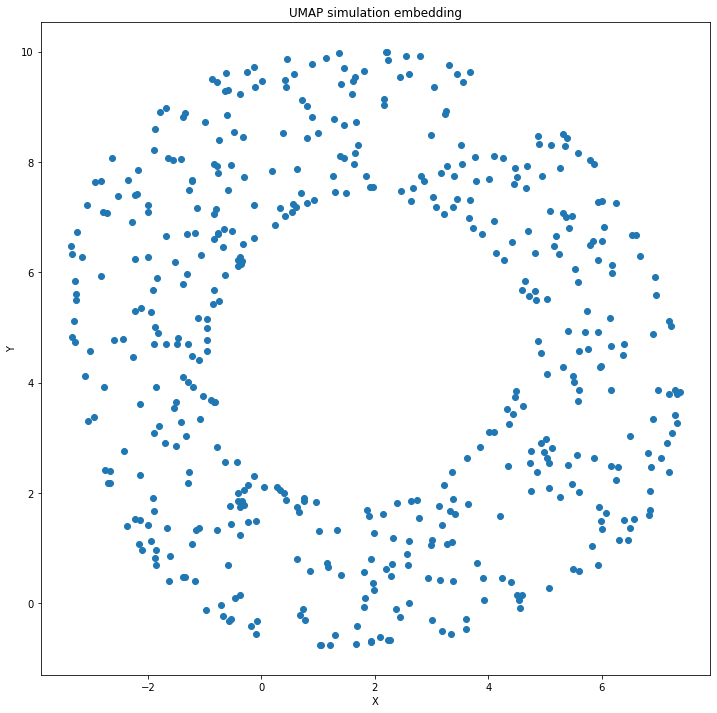

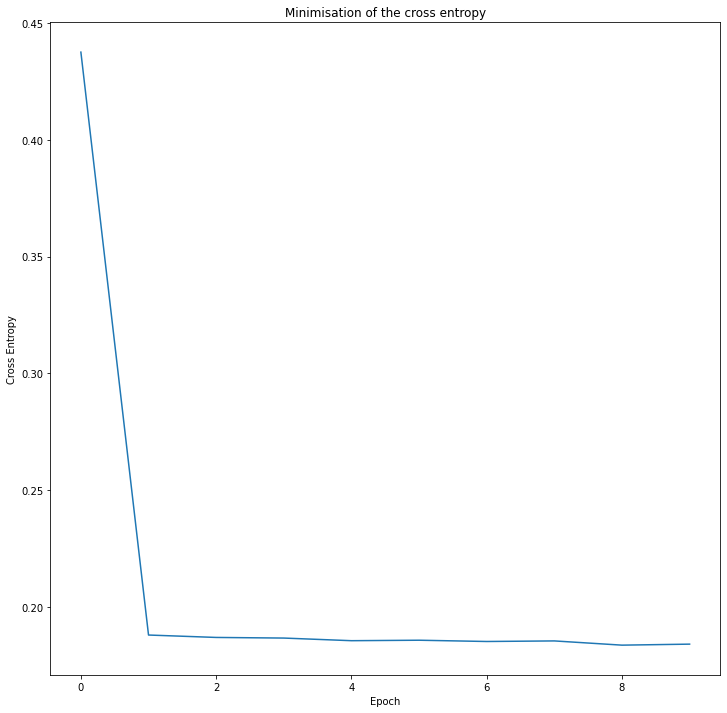

In [75]:
reconstruction = True
embedder, embedding_param = PUMAP_mapping(cells,'simulation parametric umap embedding_cluster',reconstruction)

1/1 [==============================] - 0s 29ms/step


2022-05-16 16:32:15.995366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


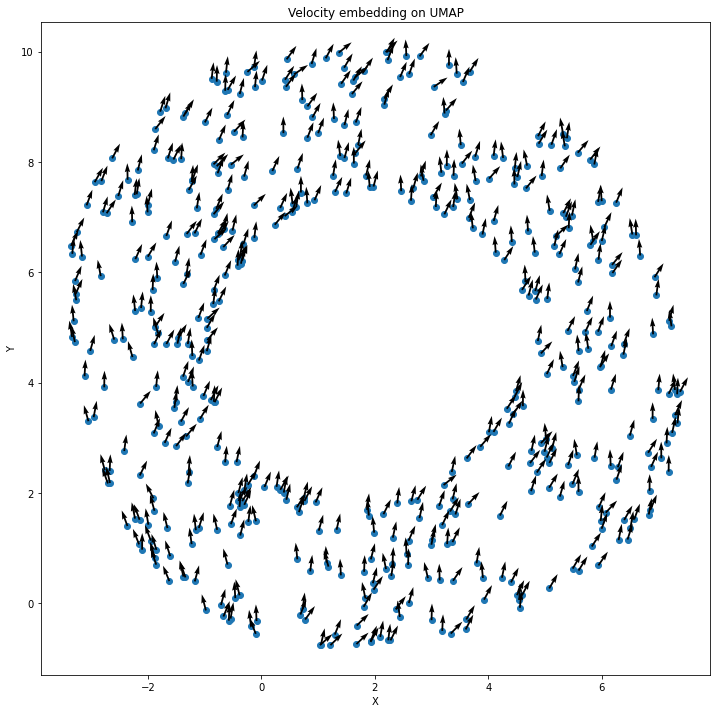

In [76]:
velo = velocity_calculus(embedder,embedding_param,velocity,cells, 'velocity M1_cluster')

1/1 [==============================] - 0s 32ms/step


2022-05-16 16:32:16.256286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


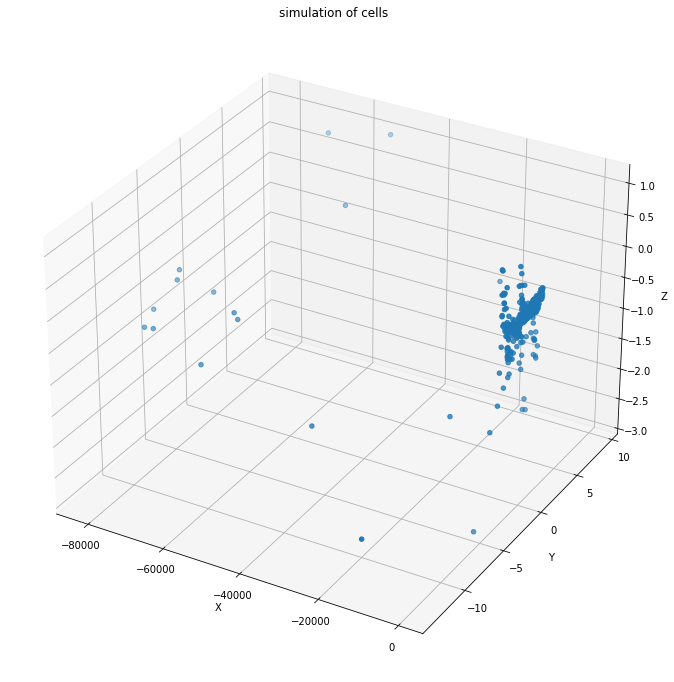

In [77]:
#Vector_plot(embedder,embedding, velocity,cells)

embedding_inverse = inversion(embedder,embedding_param,'inverse plot_cluster')

In [ ]:
#dist(cells, embedding_inverse)

In [78]:
embedded_velocity = velocity_embedding(cells,embedder,velocity)

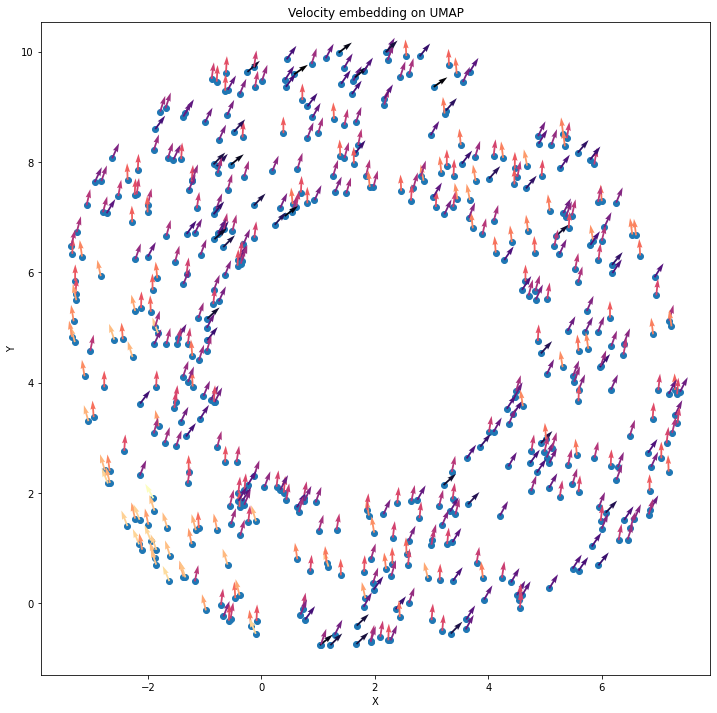

In [79]:
Vector_plot(embedding_param, embedded_velocity,'velocity embedding plot_cluster',True)

In [ ]:
#dist(velo,embedded_velocity)

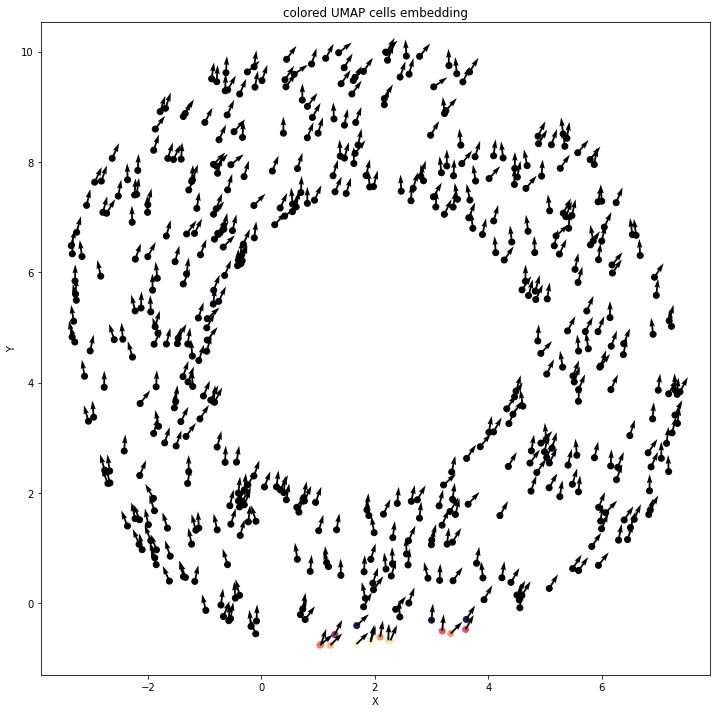

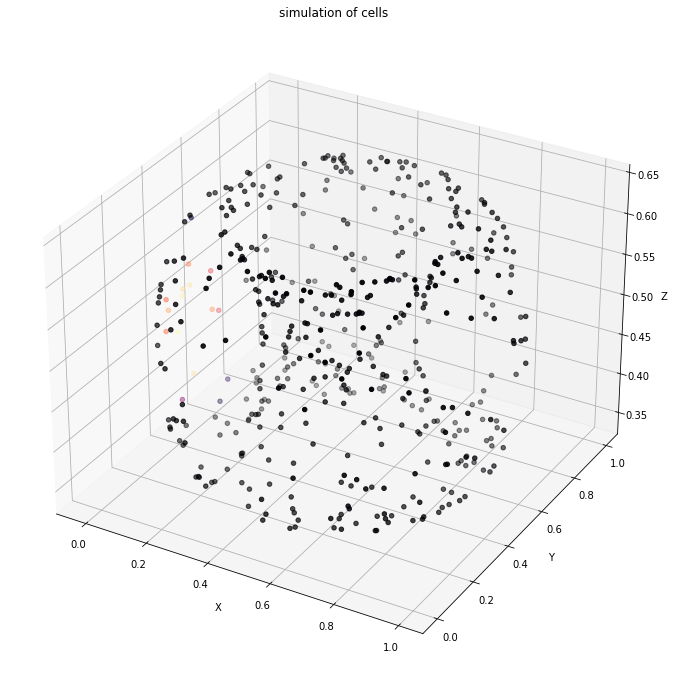

In [80]:
coloring(cells, embedding_inverse,embedding_param, embedded_velocity,'colored embedding plot_cluster')

1/1 [==============================] - 0s 7ms/step


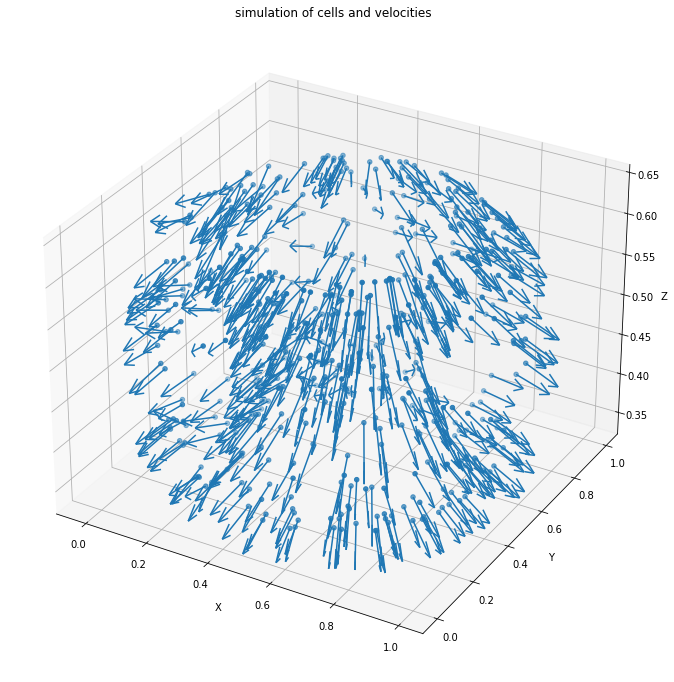

In [81]:
velo_invert = velocity_inverting(embedder,embedding_param,embedded_velocity,cells)

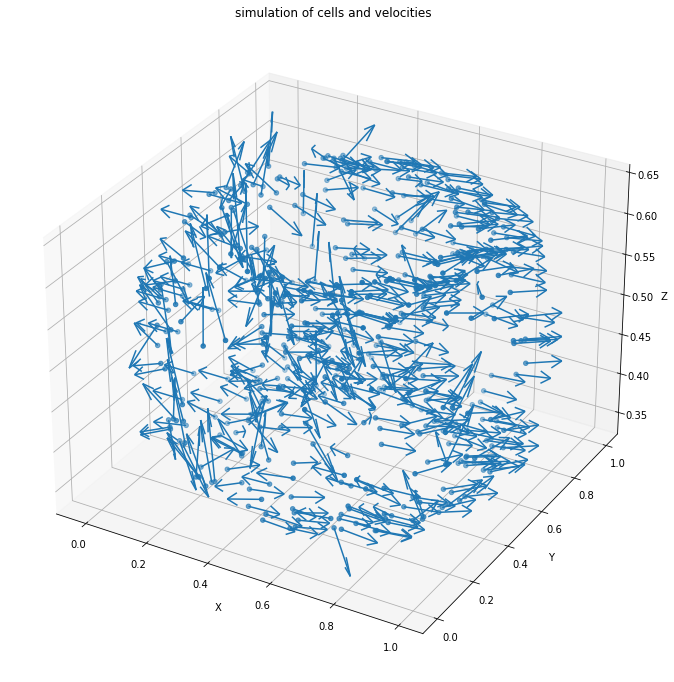

In [82]:
if (reconstruction == True) :
    velo_invert2 = velocity_inversing(embedding_param,embedder,embedded_velocity)
    Vector_plot3D(cells,velo_invert2, 'simulation of velocity_cluster')
    dist(velo_invert2, velocity)

# <b>Non-random data : exemple with a biological dataset<b>

In [42]:
data = scv.datasets.dentategyrus() # or other ?
scv.pp.filter_and_normalize(data)
scv.pp.moments(data)
scv.tl.velocity(data, mode='stochastic')
velocity_p = data.layers['velocity']

#data_p = normalise(data.X.toarray())
data_p = data.X.toarray()
umap_p = data.obsm['X_umap'] 

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


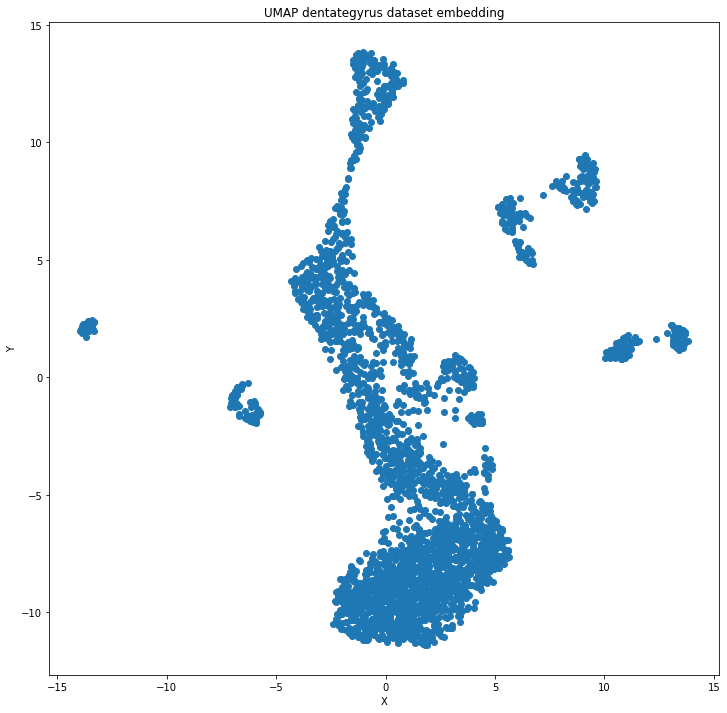

In [43]:
#plot
plt.figure(figsize=(12, 12))
plt.title("UMAP dentategyrus dataset embedding")
plt.xlabel('X')
plt.ylabel('Y')

plt.scatter(umap_p[:, 0],
    umap_p[:, 1])

plt.savefig(fname = 'graph/original umap.png')

plt.show()

 # Embedding of the vector field using scvelo

In [44]:
scv.tl.velocity_graph(data)

computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus dataset.pdf


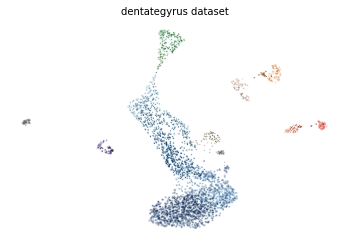

saving figure to file ./figures/scvelo_dentategyrus dataset grid.pdf


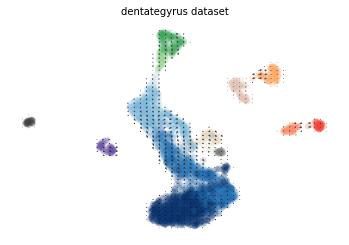

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_dentategyrus dataset stream.png


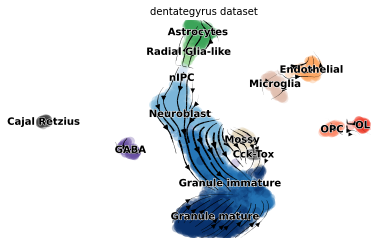

In [45]:
scv.pl.velocity_embedding(data, basis="umap", title = "dentategyrus dataset", save = 'dentategyrus dataset')
scv.pl.velocity_embedding_grid(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset grid')
scv.pl.velocity_embedding_stream(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset stream')

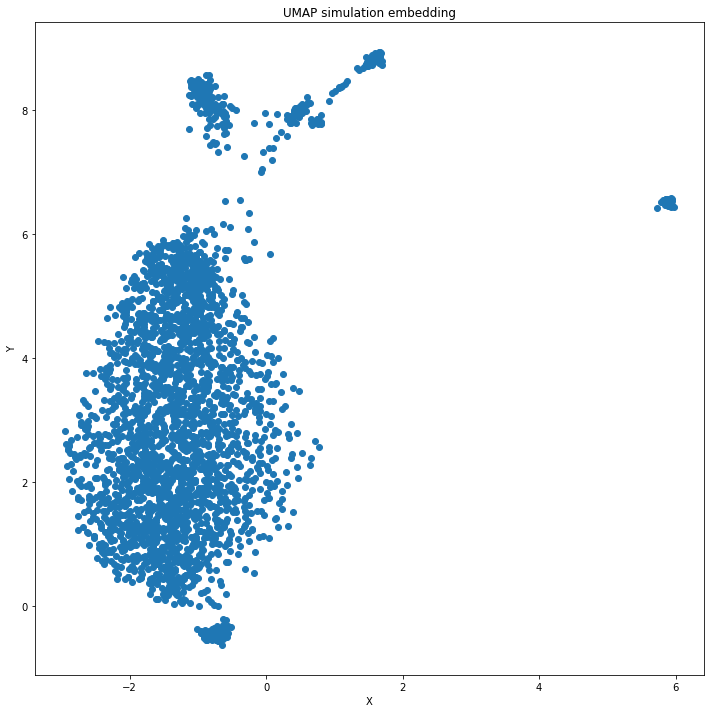

In [46]:
embedding = umap_mapping(data_p,'bio umap embedding')

ParametricUMAP(optimizer=<keras.optimizer_v2.adam.Adam object at 0x2d82eef40>, parametric_reconstruction=True)
Mon May 16 15:57:20 2022 Construct fuzzy simplicial set
Mon May 16 15:57:36 2022 Finding Nearest Neighbors
Mon May 16 15:57:36 2022 Finished Nearest Neighbor Search
Mon May 16 15:57:36 2022 Construct embedding
Epoch 1/10


2022-05-16 15:57:43.680225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1130/1130 [==============================] - 93s 81ms/step - loss: -34823.5234 - reconstruction_loss: -34823.9219 - umap_loss: 0.4033
Epoch 2/10
1130/1130 [==============================] - 92s 82ms/step - loss: -561334.1250 - reconstruction_loss: -561334.5000 - umap_loss: 0.3813
Epoch 3/10
1130/1130 [==============================] - 306s 271ms/step - loss: -2665794.5000 - reconstruction_loss: -2665795.0000 - umap_loss: 0.3790
Epoch 4/10
1130/1130 [==============================] - 155s 138ms/step - loss: -8767882.0000 - reconstruction_loss: -8767882.0000 - umap_loss: 0.3775
Epoch 5/10
1130/1130 [==============================] - 92s 82ms/step - loss: -21451884.0000 - reconstruction_loss: -21451884.0000 - umap_loss: 0.3760
Epoch 6/10
1130/1130 [==============================] - 93s 82ms/step - loss: -45000480.0000 - reconstruction_loss: -45000480.0000 - umap_loss: 0.3752
Epoch 7/10
1130/1130 [==============================] - 93s 82ms/step - loss: -90147896.0000 - reconstruction_loss:

2022-05-16 16:17:25.713286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 0s 3ms/step
Mon May 16 16:17:26 2022 Finished embedding


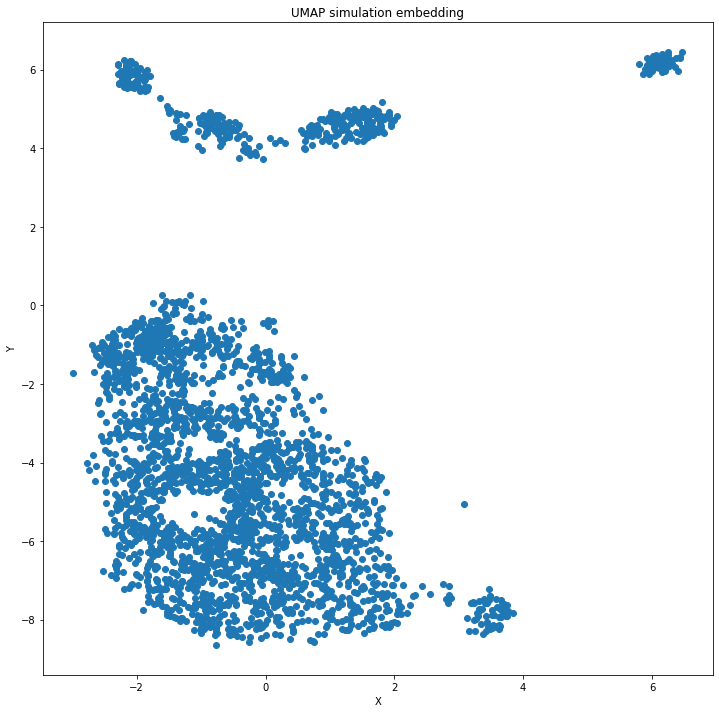

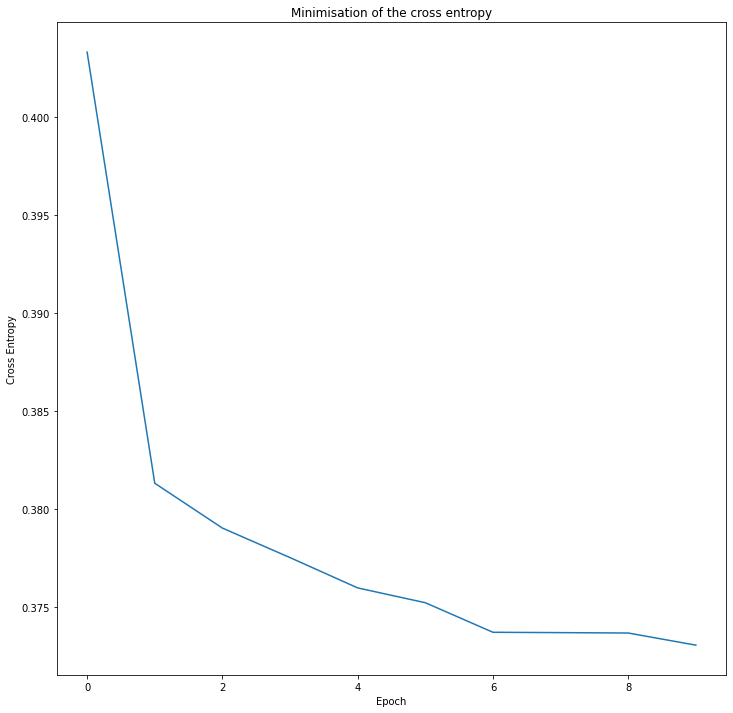

In [47]:
reconstruction = True
embedder, embedding_param = PUMAP_mapping(data_p, 'bio parametric umap embedding',reconstruction)

3/3 [==============================] - 0s 25ms/step


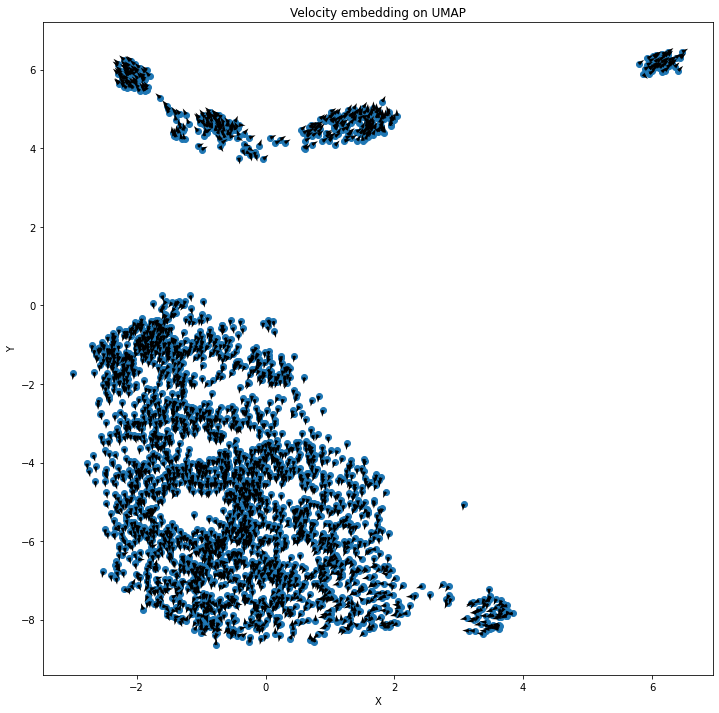

In [48]:
velo = velocity_calculus(embedder,embedding_param,velocity_p,data_p,'bio velocity m1 embedding') #method 1

In [49]:
embedded_velocity = velocity_embedding(data_p,embedder,velocity_p)

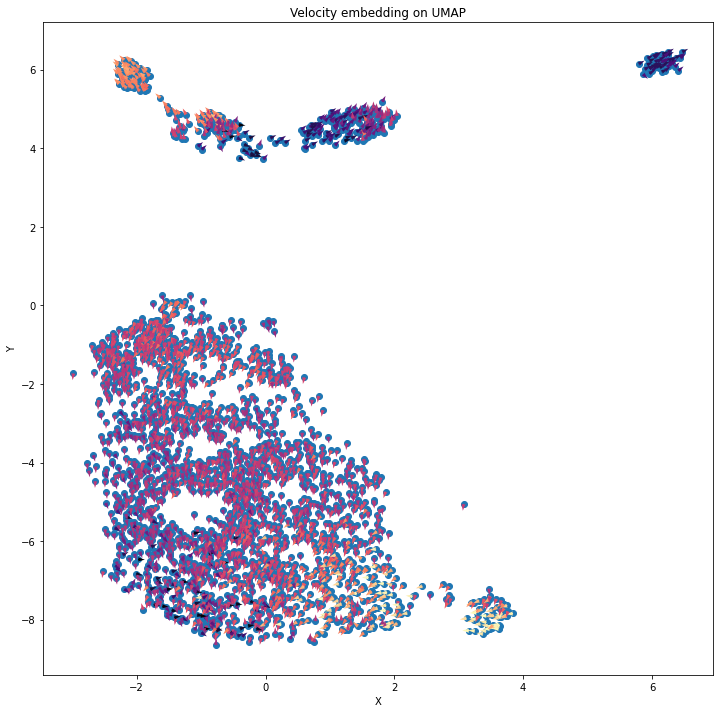

In [50]:
Vector_plot(embedding_param, embedded_velocity,'bio velocity embedding', True)

In [51]:
dist(velo,embedded_velocity)

0.001504748402831195

saving figure to file ./figures/scvelo_dentategyrus dataset umap.pdf


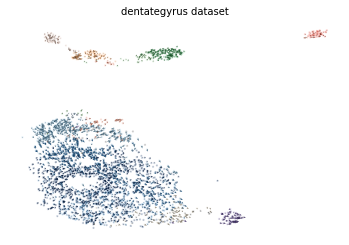

saving figure to file ./figures/scvelo_dentategyrus dataset umap grid.pdf


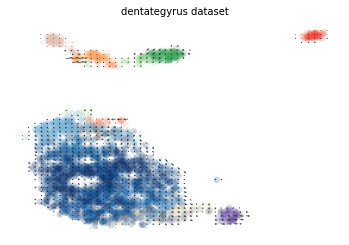

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_dentategyrus dataset umap stream.png


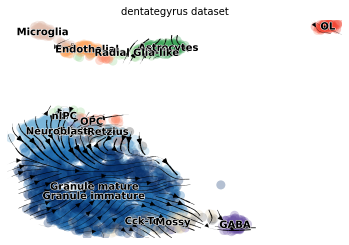

In [52]:
data.obsm['X_umap'] = embedding_param
scv.pl.velocity_embedding(data, basis="umap", title = "dentategyrus dataset", save = 'dentategyrus dataset umap')
scv.pl.velocity_embedding_grid(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset umap grid')
scv.pl.velocity_embedding_stream(data, basis='umap', title = "dentategyrus dataset", save = 'dentategyrus dataset umap stream')

In [53]:
embedding_inverse = inversion(embedder,embedding_param,'inverse plot_bio')

3/3 [==============================] - 0s 13ms/step


2022-05-16 16:18:55.110608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


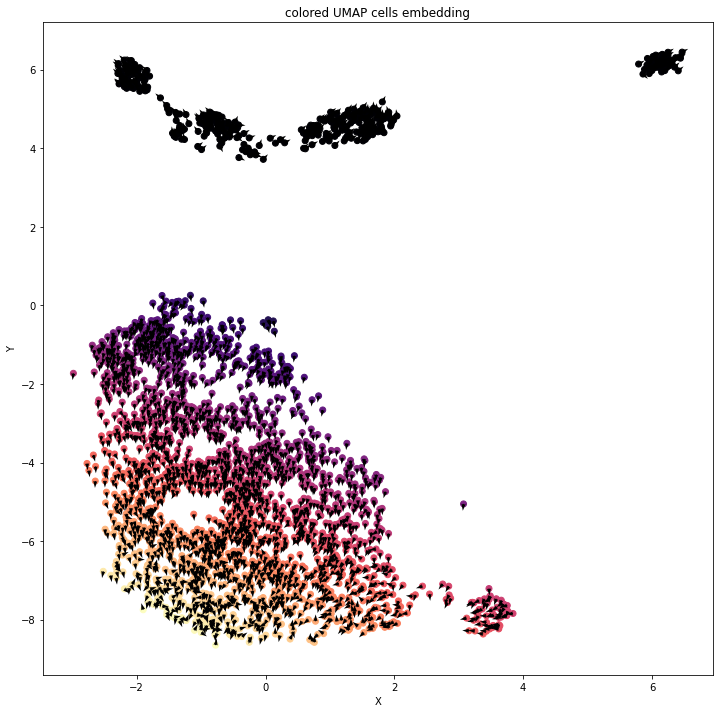

In [54]:
coloring(data_p, embedding_inverse,embedding_param, embedded_velocity,'colored embedding plot_bio')

In [55]:
if (reconstruction == True) :
    velo_invert2 = velocity_inversing(embedding_param,embedder,embedded_velocity)

# <b>PCA ground truth : comparison between jacobian and scVelo method